In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
id='1QmKZzdrnNfSZ0RWrW89d6V_SG8cp03AK'
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile('consolidated_tweets_df.csv')

id='1_pp8dvoiEjWRRAu48KwcSYBsTcLKywUU'
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile('consolidated_retweets_df.csv')  

# get topic clusters
id='12Vy0ZqeL7w4tuv7_-i0amHkt2pC0dxO0'
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile('res_cluster.csv')

id='13X3b0q3l1CfiMiKD5bRQgA_YU1ldCp6N'
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile('results_basic_lda.csv')

id='1oQA5tyGO_G6yxqZ4YVeSU7JgZgDK2PPL'
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile('results_equal_cluster.csv')

In [62]:
# Let's import the libraries we will need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
#user_tweets = pd.read_csv("consolidated_user.csv", lineterminator='\n', dtype = {"tweet_id": str, "user_id": str})
#user_tweets = user_tweets.drop(columns = ['Unnamed: 0', "Unnamed: 0.1"])
#print(user_tweets.shape)
#user_tweets.head()

In [5]:
tweets_data = pd.read_csv("consolidated_tweets_df.csv", lineterminator='\n', dtype = {"tweet_id": object, "article_id": object, "tweet_created_at": str, "user_id" : str}, parse_dates = ['tweet_created_at'])
tweets_data = tweets_data.drop(columns = ["Unnamed: 0"])
print(tweets_data.shape)
tweets_data.head()

(213823, 7)


,article_id,tweet_id,tweet_created_at,retweet_count,user_id,cold_user,test
0,politifact13013,771487002575286273,2016-09-01 23:16:49+00:00,0,313584104,1,0
1,politifact13013,771271973229826048,2016-09-01 09:02:22+00:00,0,10480592,1,0
2,politifact13013,771288677557280768,2016-09-01 10:08:45+00:00,0,175844074,1,0
3,politifact13013,771223329214566400,2016-09-01 05:49:04+00:00,0,2577100238,1,0
4,politifact13013,771475597918740481,2016-09-01 22:31:30+00:00,0,453088398,1,0


In [6]:
retweets_data = pd.read_csv("consolidated_retweets_df.csv", dtype={"tweet_id": str, "retweet_id" : str, "retweet_created_at":str, "retweet_user_id": str}, parse_dates=['retweet_created_at'])
retweets_data = retweets_data.drop(columns=['Unnamed: 0'])
print(retweets_data.shape)
retweets_data.head()

(32646, 9)


,article_id,tweet_id,retweet_id,retweet_count,retweet_created_at,retweet_user_id,is_quote_status,cold_user,test
0,politifact13013,771417626513772544,771420531291787264,1,2016-09-01 18:52:41+00:00,49053573,0.0,0,0
1,politifact13013,771130571489550336,771130907533139973,1,2016-08-31 23:41:49+00:00,2935416411,0.0,1,0
2,politifact13013,773849741524344832,773871933574279168,1,2016-09-08 13:13:41+00:00,862238221,0.0,1,0
3,politifact13013,771316782934155264,771585933787340800,1,2016-09-02 05:49:56+00:00,318417786,0.0,1,0
4,politifact13013,771078878529892353,771079225751339009,1,2016-08-31 20:16:28+00:00,2611772656,0.0,1,0


In [128]:
article_topics = pd.read_csv("results_basic_lda.csv", header = 0)
article_topics = article_topics.rename(columns = {'cluster': 'Topic'})
article_topics.head()

,article_id,Topic
0,politifact1820,14
1,politifact537,14
2,politifact12104,14
3,politifact12755,14
4,politifact1216,2


In [0]:
tweet_user_articles = tweets_data.join(article_topics.set_index("article_id"), on = 'article_id')
tweet_user_articles['month'] = tweet_user_articles.apply (lambda row: row['tweet_created_at'].month, axis=1)
tweet_user_articles = tweet_user_articles[['user_id', 'article_id', 'month', 'Topic']]
tweet_user_articles = tweet_user_articles.drop_duplicates()

In [130]:
tweet_user_articles.head()

,user_id,article_id,month,Topic
0,313584104,politifact13013,9,14
1,10480592,politifact13013,9,14
2,175844074,politifact13013,9,14
3,2577100238,politifact13013,9,14
4,453088398,politifact13013,9,14


In [131]:
tweet_user_articles[tweet_user_articles.Topic.isna()].article_id.unique()

array([], dtype=object)

In [0]:
retweet_user_articles = retweets_data.join(article_topics.set_index("article_id"), on = 'article_id')
retweet_user_articles['month'] = retweet_user_articles.apply (lambda row: row['retweet_created_at'].month, axis=1)
retweet_user_articles = retweet_user_articles[['retweet_user_id', 'article_id', 'month', 'Topic']]
retweet_user_articles = retweet_user_articles.drop_duplicates()
retweet_user_articles = retweet_user_articles.rename(columns={'retweet_user_id': 'user_id'})

In [53]:
retweet_user_articles.head()

,user_id,article_id,month,Topic
0,49053573,politifact13013,9,8
1,2935416411,politifact13013,8,8
2,862238221,politifact13013,9,8
3,318417786,politifact13013,9,8
4,2611772656,politifact13013,8,8


In [133]:
retweet_user_articles[retweet_user_articles.Topic.isna()].article_id.unique()

array([], dtype=object)

In [0]:
user_articles_bytime = pd.concat([tweet_user_articles, retweet_user_articles], ignore_index=True)

In [135]:
len(user_articles_bytime.user_id.unique())

175378

In [119]:
np.count_nonzero(user_articles_bytime.article_id.isna())

0

In [136]:
articles_at_t = user_articles_bytime.groupby('month')['article_id'].nunique().reset_index().rename(columns={'article_id':'num_of_articles'})
articles_at_t.head()

,month,num_of_articles
0,1,147
1,2,162
2,3,164
3,4,153
4,5,165


In [137]:
articles_in_topics_at_t = user_articles_bytime.groupby(['month', 'Topic'])['article_id'].nunique().reset_index().rename(columns={'article_id':'num_of_articles_in_topic'})
articles_in_topics_at_t.head()

,month,Topic,num_of_articles_in_topic
0,1,2,33
1,1,4,2
2,1,9,12
3,1,12,13
4,1,14,87


In [0]:
months = [1,2,3,4,5,6,7,8,9,10,11,12]
topic_count_over_time = []

labels = []
for topic in articles_in_topics_at_t.Topic.unique():
  topic_count = []
  for month in months:
    count = list(articles_in_topics_at_t[(articles_in_topics_at_t.month == month) & (articles_in_topics_at_t.Topic == topic)].num_of_articles_in_topic.values)
    if len(count) == 0:
      count = [0]
    topic_count = topic_count + count
  topic_count_over_time.append(topic_count)
  labels.append(topic)
topic_count_over_time = np.array(topic_count_over_time)

In [0]:
topic_count_over_time = np.array([x for y,x in sorted(zip(labels,topic_count_over_time))])
labels = sorted(labels)

In [0]:
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec' ]

In [0]:
import matplotlib.font_manager as fm
import matplotlib as mpl
from pylab import cm
from matplotlib.pyplot import imshow
# Collect all the font names available to matplotlib
font_names = [f.name for f in fm.fontManager.ttflist]

fm._rebuild()

mpl.rcParams['font.family'] = 'Avenir'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 2
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

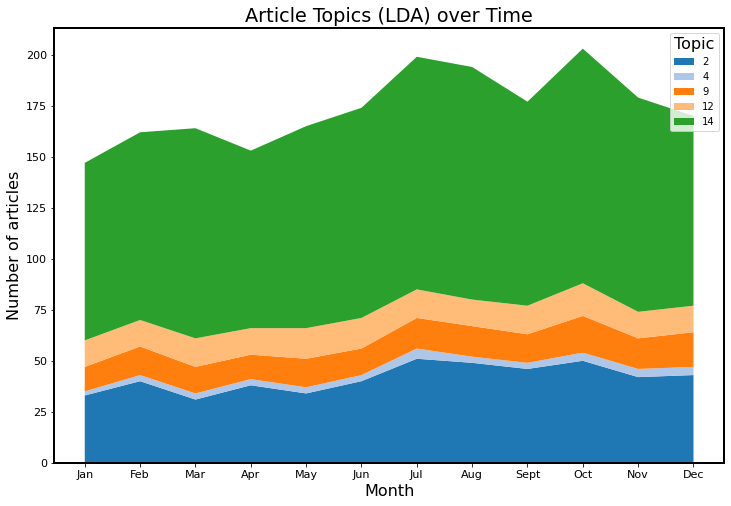

In [142]:
fig = plt.figure(figsize=(12,8))
#pal = sns.color_palette("muted", 20)
pal = plt.cm.tab20.colors
plt.stackplot(month_labels, topic_count_over_time, labels=labels, colors=pal)
plt.xlabel('Month')
plt.ylabel('Number of articles')
plt.legend(title = "Topic", fontsize = 10)
plt.title("Article Topics (LDA) over Time")
plt.savefig('lda_tot_count.png')

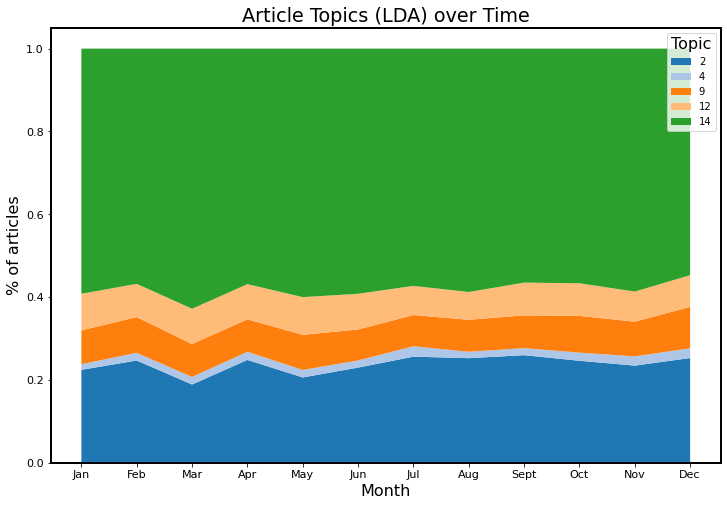

In [143]:
topic_perc_over_time = topic_count_over_time/topic_count_over_time.sum(axis=0)[np.newaxis, :]
fig = plt.figure(figsize=(12,8))
plt.xlabel('Month')
plt.ylabel('% of articles')
plt.stackplot(month_labels, topic_perc_over_time, labels=labels, colors = pal)
plt.legend(title = "Topic", fontsize = 10)
plt.title("Article Topics (LDA) over Time")
plt.savefig('lda_tot_perc.png')

In [22]:
p_topic_at_t = articles_at_t.join(articles_in_topics_at_t.set_index('month'), on= 'month')
p_topic_at_t['prob'] = p_topic_at_t.apply (lambda row: row['num_of_articles_in_topic']/ row['num_of_articles'], axis=1)
p_topic_at_t.head()

,month,num_of_articles,Topic,num_of_articles_in_topic,prob
0,1,147,0,33,0.224490
0,1,147,1,26,0.176871
0,1,147,2,30,0.204082
0,1,147,3,31,0.210884
0,1,147,4,27,0.183673


In [0]:
num_articles_by_users_at_t = user_articles_bytime.groupby(['user_id','month'])['article_id'].nunique().reset_index().rename(columns={'article_id': 'num_of_articles'})

In [0]:
num_article_topics_by_users = user_articles_bytime.groupby(['user_id','month', 'Topic'])['article_id'].nunique().reset_index().rename(columns={'article_id': 'num_of_articles_in_topic'})

In [25]:
p_user_topic_at_t = num_articles_by_users_at_t.join(num_article_topics_by_users.set_index(['user_id','month']), on= ['user_id','month'])
p_user_topic_at_t['prob'] = p_user_topic_at_t.apply (lambda row: row['num_of_articles_in_topic']/ row['num_of_articles'], axis=1)
p_user_topic_at_t.head()

,user_id,month,num_of_articles,Topic,num_of_articles_in_topic,prob
0,1000006825041973254,7,1,0,1,1.0
1,1000011520099737600,7,1,3,1,1.0
2,100001583,11,1,1,1,1.0
3,1000017210381819904,6,1,1,1,1.0
4,1000030989110870016,7,1,1,1,1.0


In [0]:
N_t = {}
user_monthwise_article_count = num_articles_by_users_at_t.set_index(['user_id','month']).T.to_dict()
for p in user_monthwise_article_count:
  if p[0] not in N_t:
    N_t[p[0]] = {}
  N_t[p[0]][p[1]] = user_monthwise_article_count[p]['num_of_articles']

In [0]:
for user in N_t:
  for month in months:
    if month not in N_t[user]:
      N_t[user][month] = 0

In [0]:
p_user_topic = {}
for index, row in p_user_topic_at_t.iterrows():
  user = row['user_id']
  month = row['month']
  topic = row['Topic']
  if user not in p_user_topic:
    p_user_topic[user] = {}
  if month not in p_user_topic[user]:
    p_user_topic[user][month] = {}
  p_user_topic[user][month][topic] = row['prob']

In [0]:
p_topic = {}
for index, row in p_topic_at_t.iterrows():
  month = row['month']
  topic = row['Topic']
  if month not in p_topic:
    p_topic[month] = {}
  p_topic[month][topic] = row['prob']

In [0]:
p_stored = {}
for user in p_user_topic:
  if user not in p_stored:
    p_stored[user] = {}
  for month in p_user_topic[user]:
    if month not in p_stored[user]:
      p_stored[user][month] = {}
    for topic in p_user_topic[user][month]:
      if topic not in p_topic[month]:
        p_stored[user][month][topic] = 0
      else:
        p_stored[user][month][topic] = p_user_topic[user][month][topic]/p_topic[month][topic]

In [0]:
tot_Nt = {}
for user in N_t:
  tot_Nt[user] = np.sum(list(N_t[user].values()))

In [0]:
numerator_term = {}
for user in p_stored:
  numerator_term[user] = {}
  for month in p_stored[user]:
    for topic in p_stored[user][month]:
      if topic not in numerator_term[user]:
        numerator_term[user][topic] = 0
      numerator_term[user][topic]+=(N_t[user][month]*p_stored[user][month][topic])

In [0]:
all_topics = article_topics.Topic.unique()

In [34]:
all_topics

array([2, 4, 0, 3, 1])

In [0]:
for user in numerator_term:
  for topic in all_topics:
    if topic not in numerator_term[user]:
      numerator_term[user][topic] = 0

In [0]:
for month in p_topic:
  for topic in all_topics:
    if topic not in p_topic[month]:
      p_topic[month][topic] = 0

In [0]:
G = np.mean(list(tot_Nt.values()))
for user in numerator_term:
  for topic in numerator_term[user]:
    numerator_term[user][topic] = (numerator_term[user][topic] + G)/(tot_Nt[user] + G)

In [0]:
import pickle
with open('bal_lda_cbf_ptopic.pickle', 'wb') as handle:
    pickle.dump(p_topic, handle)

In [0]:
with open('bal_lda_cbf_puser.pickle', 'wb') as handle:
    pickle.dump(numerator_term, handle)

In [40]:
# get article popularity for all topics
article_read_counts = user_articles_bytime.groupby(['Topic', 'article_id'])['user_id'].nunique().reset_index().rename(columns={'user_id':'read_count'})
article_read_counts = article_topics.join(article_read_counts.set_index(['Topic', 'article_id']), on = ['Topic', 'article_id'], how='left')
article_read_counts['read_count'] = article_read_counts['read_count'].fillna(0)
article_read_counts['rank'] = article_read_counts.groupby('Topic')['read_count'].rank("dense", ascending=False)
article_read_counts.sort_values(['Topic', 'rank'], ascending=['True', 'True'], inplace=True)
article_read_counts

,article_id,Topic,read_count,rank
308,politifact1213,0,6691.0,1.0
266,politifact954,0,5561.0,2.0
273,politifact14036,0,3967.0,3.0
250,politifact13420,0,3793.0,4.0
277,politifact7923,0,1505.0,5.0
...,...,...,...,...
182,politifact13260,4,0.0,56.0
189,politifact13431,4,0.0,56.0
194,politifact12924,4,0.0,56.0
204,politifact1204,4,0.0,56.0


In [0]:
article_topic_ranks = {}
for index, row in article_read_counts.iterrows():
  topic = row['Topic']
  article = row['article_id']
  rank = row['rank']
  if topic not in article_topic_ranks:
    article_topic_ranks[row['Topic']] = {}
  article_topic_ranks[topic][article] = rank

for topic in article_topic_ranks:
  article_topic_ranks[topic] = {k: v for k, v in sorted(article_topic_ranks[topic].items(), key=lambda item: item[1])}

In [0]:
import pickle
with open('bal_lda_cbf_article_rank.pickle', 'wb') as handle:
    pickle.dump(article_topic_ranks, handle)